# Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset Generation

In [2]:
def generate_dataset(N=1000, features=3, classes=5):
    dataset = []

    for c in range(classes):
        samples = np.random.randn(N//classes, features) + np.random.randn(features)
        label = np.full((N//classes, 1), c)
        dataset.append(np.concatenate([samples, label], axis=1))

    dataset = np.concatenate(dataset, axis=0)
    np.random.shuffle(dataset)
    return dataset

In [18]:
def generate_spiral(n_points=1000, classes=5):
    X = []
    y = []
    for class_id in range(classes):
        ix = range(n_points//classes)
        r = np.linspace(0.0, 1, n_points//classes)     # radius
        t = np.linspace(class_id*4, class_id*4 + 4, n_points//classes) + np.random.randn(n_points//classes)*0.2
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        x3 = r * np.sin(t*0.5) # extra feature adds complexity
        X.append(np.c_[x1, x2, x3])
        y.append(np.full(n_points//classes, class_id))
    return np.vstack(X), np.hstack(y)


In [19]:
dataset_linear = generate_dataset(N=1000, features=3, classes=5)

In [20]:
dataset_spiral = generate_spiral()

In [21]:
dataset_linear[:5]

array([[-2.17766001,  1.3515048 , -1.46418781,  3.        ],
       [-0.27753653,  0.28788033, -2.65304588,  3.        ],
       [-1.95471493, -1.70464188, -1.0845061 ,  2.        ],
       [-2.74687988,  0.50110803, -0.14178505,  1.        ],
       [-0.71360215,  1.85411543, -0.95072579,  0.        ]])

In [23]:
dataset_spiral[:1]

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.10316755e-04,  4.94198452e-03,  4.57052798e-04],
        [-1.69818888e-03,  9.90574100e-03, -8.52163232e-04],
        ...,
        [ 8.17156491e-01,  5.58798509e-01, -4.61962153e-01],
        [ 9.50113620e-01,  2.95396530e-01, -5.89941893e-01],
        [ 8.12901564e-01,  5.82401105e-01, -4.56945782e-01]],
       shape=(1000, 3)),)

In [14]:
# generate data
X_linear, y_linear = dataset_linear[:, :3], dataset_linear[:, 3].astype(int)
X_spiral, y_spiral = dataset_spiral[0], dataset_spiral[1].astype(int)

In [16]:
X_linear.shape, y_linear.shape, X_spiral.shape, y_spiral.shape

((1000, 3), (1000,), (2000, 3), (2000,))

In [17]:
spiral = True

if spiral:
    X, y = X_spiral, y_spiral
else:
    X, y = X_linear, y_linear

In [30]:
# shuffle dataset
indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

In [31]:
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train].astype(int)
X_test, y_test = X[n_train:], y[n_train:].astype(int)

In [32]:
def one_hot(y_true):
    one_hot_y = np.zeros((y_true.shape[0], 5))
    one_hot_y[np.arange(y_true.shape[0]), y_true] = 1
    return one_hot_y

In [33]:
y_train_one_hot = one_hot(y_train)
y_test_one_hot = one_hot(y_test)

In [34]:
y_train_one_hot[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [35]:
y_test_one_hot[:5]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [38]:
def cross_entropy(y_true, y_pred):
    '''
    Cross-entropy mathematical formula
    loss = -1/N * [y_true_0 * log(y_pred_0) + y_true_1 * log(y_pred_1) + ... + y_true_n * log(y_pred_n)]
    where N is the number of samples
    1e-9 is added to y_pred to avoid log(0)
    '''
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))


In [ ]:
def confusion_counts(y_true, y_pred):
    TP = FP = TN = FN = 0
    for t, p in zip(y_true, y_pred):
        if t == 1 and p == 1:
            TP += 1
        elif t == 0 and p == 1:
            FP += 1
        elif t == 0 and p == 0:
            TN += 1
        elif t == 1 and p == 0:
            FN += 1
    return TP, FP, TN, FN

In [57]:
class NeuralNetwork(object):
    def __init__(self, input_size=3, hidden1_size=8, hidden2_size=6, hidden3_size=4, output_size=5, learning_rate=0.01):
        # neuron size per layer
        self.inputLayerNeurons = input_size       # 3
        self.hiddenLayer1Neurons = hidden1_size   # 8
        self.hiddenLayer2Neurons = hidden2_size   # 6
        self.hiddenLayer3Neurons = hidden3_size   # 4
        self.outputLayerNeurons = output_size     # 5

        self.learning_rate = learning_rate
        self.error = []
        self.val_error = []

        # weights (He initialization)
        # He initilization is the default for relu activation function
        self.W1 = np.random.randn(self.inputLayerNeurons, self.hiddenLayer1Neurons) * np.sqrt(2/self.inputLayerNeurons)     # 3x8
        self.W2 = np.random.randn(self.hiddenLayer1Neurons, self.hiddenLayer2Neurons) * np.sqrt(2/self.hiddenLayer1Neurons) # 8x6
        self.W3 = np.random.randn(self.hiddenLayer2Neurons, self.hiddenLayer3Neurons) * np.sqrt(2/self.hiddenLayer2Neurons) # 6x4
        self.W4 = np.random.randn(self.hiddenLayer3Neurons, self.outputLayerNeurons) * np.sqrt(2/self.hiddenLayer3Neurons)  # 4x5

        # biases (zeros)
        # bias initialization to zero for relu
        self.b1 = np.zeros((self.hiddenLayer1Neurons,))   # (8,)
        self.b2 = np.zeros((self.hiddenLayer2Neurons,))   # (6,)
        self.b3 = np.zeros((self.hiddenLayer3Neurons,))   # (4,)
        self.b4 = np.zeros((self.outputLayerNeurons,))    # (5,)

    def relu(self, x, der=False):
        '''
        mathematical formula:
        relu(x) = max(0, x)
        relu'(x) = 1 if x > 0, else 0
        '''
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def softmax(self, z):
      '''
      mathematical formula:
      softmax(x_i) = exp(x_i) / sum(exp(x_j)) for all j
      For numerical stability: softmax(x_i) = exp(x_i - max(x)) / sum(exp(x_j - max(x)))
      '''
      z = z - np.max(z, axis=1, keepdims=True)
      e_z = np.exp(z)
      return e_z / np.sum(e_z, axis=1, keepdims=True)


    def feedForward(self, X):
        # X: (N,3)
        '''
        Forward Pass flow:
        1: X -> W1,b1 -> z1 -> relu -> h1
        2: h1 -> W2,b2 -> z2 -> relu -> h2
        3: h2 -> W3,b3 -> z3 -> relu -> h3
        4: h3 -> W4,b4 -> z4 -> softmax -> output
        '''

        # 1: X -> W1,b1 -> z1 -> relu -> h1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.h1 = self.relu(self.z1)

        # 2: h1 -> W2,b2 -> z2 -> relu -> h2
        self.z2 = np.dot(self.h1, self.W2) + self.b2
        self.h2 = self.relu(self.z2)

        # 3: h2 -> W3,b3 -> z3 -> relu -> h3
        self.z3 = np.dot(self.h2, self.W3) + self.b3
        self.h3 = self.relu(self.z3)

        # 4: h3 -> W4,b4 -> z4 -> softmax -> output
        self.z4 = np.dot(self.h3, self.W4) + self.b4
        self.output = self.softmax(self.z4)

        return self.output

    def backPropagation(self, X, y_true):
        m = X.shape[0]

        '''
        Back Propagation flow:
        1: output -> W4,b4 -> h3
        2: h3 -> W3,b3 -> h2
        3: h2 -> W2,b2 -> h1
        4: h1 -> W1,b1 -> X
        5: gradient descent step
        6: update weights and biases
        7: repeat for all layers
        8: done
        '''

        # output layer
        '''
        output: [a,b,c,d,e] and y_true: [0,0,1,0,0]
        dz4 = output - y_true ([a,b,c-1,d,e])
        dW4 = h3^T . dz4 / m 
        db4 = sum(dz4) / m
        '''
        dz4 = self.output - y_true        # (5,) - (5,) = (5,)
        dW4 = np.dot(self.h3.T, dz4) / m  # (4,)^T . (5,) = (4,5)
        db4 = np.sum(dz4, axis=0) / m     # (5,)

        # hidden layers
        # chain rule: dz = dh * relu'(z)
        # where dh = dz * W^T
        # and relu'(z) = 1 if z > 0 else 0
        dh3 = np.dot(dz4, self.W4.T)                 # (5,) . (4,5)^T = (4,)
        dz3 = dh3 * self.relu(self.z3, der=True)     # (4,) * (4,) = (4,)
        dW3 = np.dot(self.h2.T, dz3) / m             # (6,)^T . (4,) = (6,4)
        db3 = np.sum(dz3, axis=0) / m                # (4,)

        dh2 = np.dot(dz3, self.W3.T)                 # (4,) . (6,4)^T = (6,)
        dz2 = dh2 * self.relu(self.z2, der=True)     # (6,) * (6,) = (6,)
        dW2 = np.dot(self.h1.T, dz2) / m             # (8,)^T . (6,) = (8,6)
        db2 = np.sum(dz2, axis=0) / m                # (6,)

        dh1 = np.dot(dz2, self.W2.T)                 # (6,) . (8,6)^T = (8,)
        dz1 = dh1 * self.relu(self.z1, der=True)     # (8,) * (8,) = (8,)
        dW1 = np.dot(X.T, dz1) / m                   # (3,)^T . (8,) = (3,8)
        db1 = np.sum(dz1, axis=0) / m                # (8,)

        # gradient descent step
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4

        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y):
        output = self.feedForward(X)
        loss = cross_entropy(y, output)
        self.error.append(loss)
        self.backPropagation(X, y)
        return loss

    def evaluate(self, X, y_true_one_hot):
      y_pred = self.feedForward(X)
      pred_classes = np.argmax(y_pred, axis=1)
      true_classes = np.argmax(y_true_one_hot, axis=1)

      # confusion matrix
      num_classes = y_true_one_hot.shape[1]
      TP, FP, TN, FN = confusion_counts(true_classes, pred_classes)

      try:
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
      except ZeroDivisionError:
        print("Division by zero encountered in metric calculation.")
        accuracy = precision = recall = f1 = 0

      cm = np.zeros((num_classes, num_classes), dtype=int)

      for t, p in zip(true_classes, pred_classes):
          cm[t, p] += 1
          if t == 1 and p == 1:
            TP += 1
          elif t == 0 and p == 1:
            FP += 1
          elif t == 0 and p == 0:
            TN += 1
          elif t == 1 and p == 0:
            FN += 1

      return {
          "accuracy": accuracy,
          "precision": precision,
          "recall": recall,
          "f1_score": f1,
          "confusion_matrix": cm,
          # "predicted_classes": pred_classes,
          # "true_classes": true_classes,
          # "probabilities": y_pred
      }

    def predict(self, X):
      pred = self.feedForward(X)
      return np.argmax(pred, axis=1)

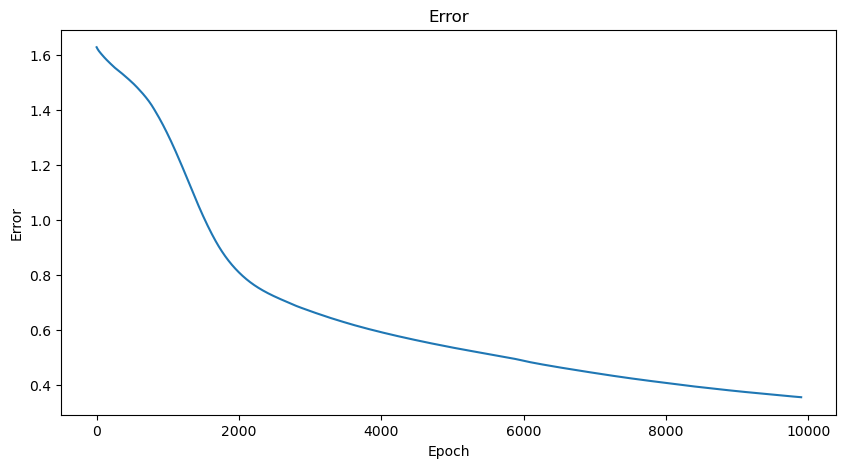

Epoch:  9900 Loss:  0.3561340712539797


In [45]:
from IPython import display

NN = NeuralNetwork()
for i in range(10000):
    NN.train(X_train, y_train_one_hot)
    loss = NN.error
    display.clear_output(wait=True)
    if i % 100 == 0:
      plt.figure(figsize=(10, 5))
      plt.plot(loss)
      plt.title("Error")
      plt.xlabel("Epoch")
      plt.ylabel("Error")
      plt.show()
      print("Epoch: ", i, "Loss: ", loss[-1])

In [46]:
NN.evaluate(X_test, y_test_one_hot)

{'accuracy': 0.9927007299270073,
 'precision': 1.0,
 'recall': 0.9861111111111112,
 'f1_score': 0.993006993006993,
 'confusion_matrix': array([[65,  0,  0, 18,  0],
        [ 1, 71,  0,  2, 11],
        [ 1,  0, 72,  0,  1],
        [16,  1,  0, 54,  0],
        [ 0, 11,  0,  0, 76]])}

In [48]:
X.shape

(2000, 3)

In [49]:
y[:10]

array([1, 2, 1, 4, 0, 4, 1, 2, 3, 4])

In [50]:
print(NN.predict(np.array(X[:10])))

[1 2 1 4 0 4 1 2 3 4]


### Different Network Architecture

- X.shape = (N, 3)
- Hidden Layer 1: 10 neurons
- Hidden Layer 2: 10 neurons
- Hidden Layer 3: 10 neurons
- Output Layer: 5 neurons

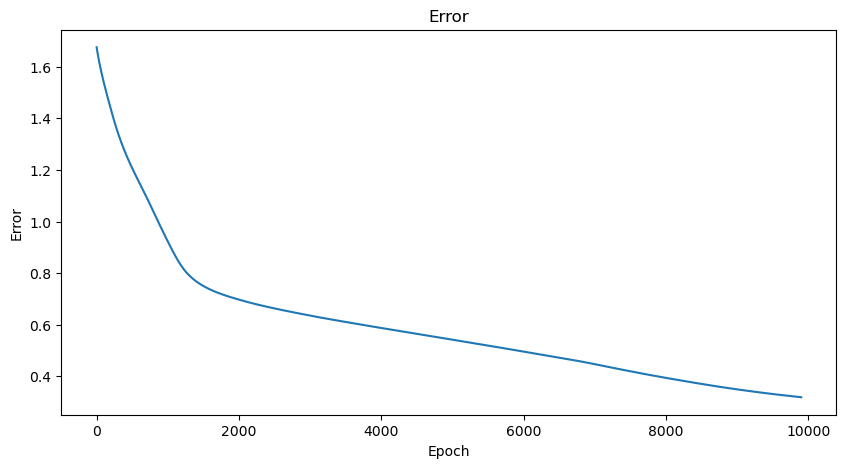

Epoch:  9900 Loss:  0.31873650436415246


In [53]:
NN2 = NeuralNetwork(hidden1_size=10, hidden2_size=10, hidden3_size=10)
for i in range(10000):
    NN2.train(X_train, y_train_one_hot)
    loss = NN2.error
    display.clear_output(wait=True)
    if i % 100 == 0:
      plt.figure(figsize=(10, 5))
      plt.plot(loss)
      plt.title("Error")
      plt.xlabel("Epoch")
      plt.ylabel("Error")
      plt.show()
      print("Epoch: ", i, "Loss: ", loss[-1])

In [58]:
NN2.evaluate(X_test, y_test_one_hot)

{'accuracy': 0.9933774834437086,
 'precision': 1.0,
 'recall': 0.9875,
 'f1_score': 0.9937106918238994,
 'confusion_matrix': array([[71,  0,  0, 12,  0],
        [ 1, 79,  0,  0,  5],
        [ 1,  2, 71,  0,  0],
        [10,  0,  0, 61,  0],
        [ 0, 12,  0,  0, 75]])}

### Different Network Architecture

- X.shape = (N, 3)
- Hidden Layer 1: 1 neurons
- Hidden Layer 2: 1 neurons
- Hidden Layer 3: 1 neurons
- Output Layer: 5 neurons

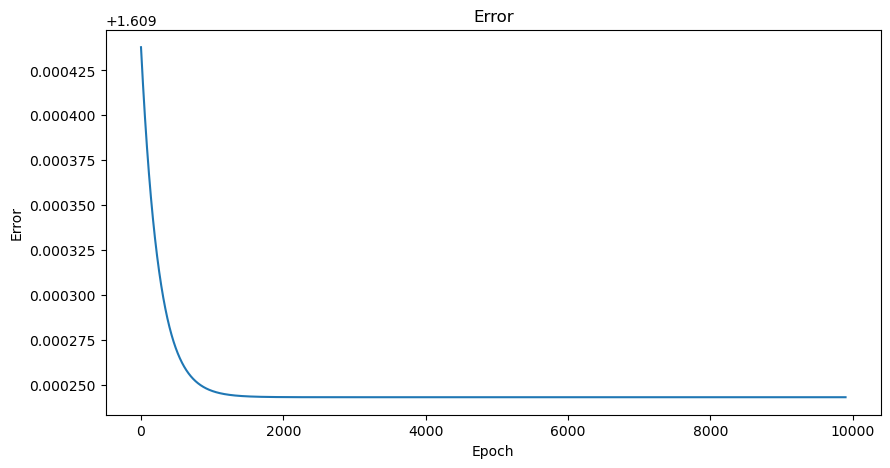

Epoch:  9900 Loss:  1.609243035405626


In [60]:
NN3 = NeuralNetwork(hidden1_size=1, hidden2_size=1, hidden3_size=1)
for i in range(10000):
    NN3.train(X_train, y_train_one_hot)
    loss = NN3.error
    display.clear_output(wait=True)
    if i % 100 == 0:
      plt.figure(figsize=(10, 5))
      plt.plot(loss)
      plt.title("Error")
      plt.xlabel("Epoch")
      plt.ylabel("Error")
      plt.show()
      print("Epoch: ", i, "Loss: ", loss[-1])

In [62]:
metrics = NN3.evaluate(X_test, y_test_one_hot)
metrics

Division by zero encountered in metric calculation.


{'accuracy': 0,
 'precision': 0,
 'recall': 0,
 'f1_score': 0,
 'confusion_matrix': array([[ 0,  0,  0, 83,  0],
        [ 0,  0,  0, 85,  0],
        [ 0,  0,  0, 74,  0],
        [ 0,  0,  0, 71,  0],
        [ 0,  0,  0, 87,  0]])}

In [63]:
metrics["confusion_matrix"]

array([[ 0,  0,  0, 83,  0],
       [ 0,  0,  0, 85,  0],
       [ 0,  0,  0, 74,  0],
       [ 0,  0,  0, 71,  0],
       [ 0,  0,  0, 87,  0]])

### Different Network Architecture

- X.shape = (N, 3)
- Hidden Layer 1: 2 neurons
- Hidden Layer 2: 2 neurons
- Hidden Layer 3: 2 neurons
- Output Layer: 5 neurons

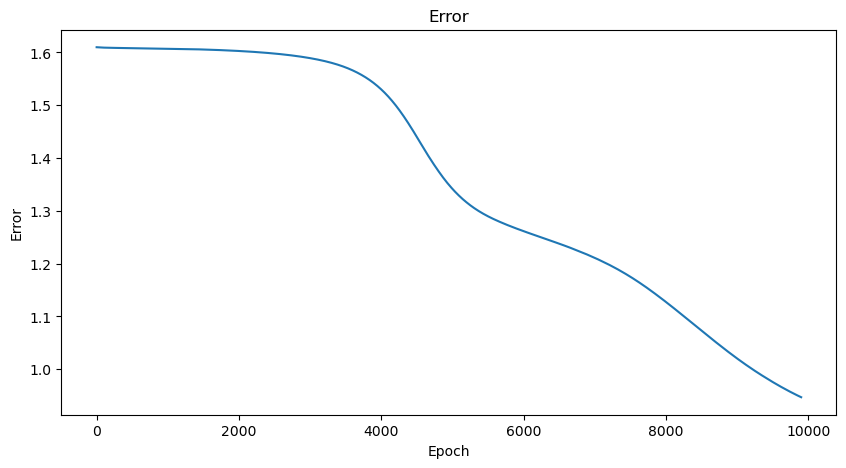

Epoch:  9900 Loss:  0.9471040609817653


In [64]:
NN3 = NeuralNetwork(hidden1_size=2, hidden2_size=2, hidden3_size=2)
for i in range(10000):
    NN3.train(X_train, y_train_one_hot)
    loss = NN3.error
    display.clear_output(wait=True)
    if i % 100 == 0:
      plt.figure(figsize=(10, 5))
      plt.plot(loss)
      plt.title("Error")
      plt.xlabel("Epoch")
      plt.ylabel("Error")
      plt.show()
      print("Epoch: ", i, "Loss: ", loss[-1])

In [65]:
metrics = NN3.evaluate(X_test, y_test_one_hot)
metrics

{'accuracy': 0.8648648648648649,
 'precision': 0.8648648648648649,
 'recall': 1.0,
 'f1_score': 0.927536231884058,
 'confusion_matrix': array([[ 0,  5,  0, 78,  0],
        [ 0, 32,  0,  4, 49],
        [ 0,  2, 63,  0,  9],
        [ 0,  6,  0, 60,  5],
        [ 0, 18,  0,  0, 69]])}

In [66]:
metrics["confusion_matrix"]

array([[ 0,  5,  0, 78,  0],
       [ 0, 32,  0,  4, 49],
       [ 0,  2, 63,  0,  9],
       [ 0,  6,  0, 60,  5],
       [ 0, 18,  0,  0, 69]])

# Discussion
- As we reduce the number of neurons in each hidden layer, the model's capacity to learn complex patterns decreases. This is reflected in the evaluation metrics, where we observe a decline in accuracy and an increase in error rates. The confusion matrix also shows that the model struggles to correctly classify certain classes, indicating that it cannot capture the underlying structure of the data as effectively as the larger network.
- We have used 2 different datasets - **linear random dataset**, **spiral random dataset**. **Linear dataset** showed frequent learning for higher neuron sizes whereas the **spiral** showed less accuracy with lower neuron sizes. This is because the **spiral dataset** is inherently more complex and requires a higher capacity model to capture its non-linear patterns effectively.
- We have also tried different activation funcitons and **sigmoid function** was facing diminishing gradient problem. The Neural Network wasn't learning anything at all. That's why we have changed the activation function to **Relu**.
- Finally, we can conclude that for simpler dataset less neurons can learn very well and more neurons makes the network overfitted. On the other hand, complex dataset gets hard time learning with less neurons but works very well with more neurons. Hence, the choice of network architecture should be made based on the complexity of the dataset and the specific task at hand.